# Neural Architecture Search (Basic)

In this tutorial we will learn the basis of neural architecture search (NAS). To do so, we will use artificial data generated from a polynomial function. Then, we will discover how to create a search space of neural architecture using a directed graph. Finally, we will see how to define the NAS settings and how to execute the search.

<div class="alert alert-warning">

<b>Warning</b>
    
By design asyncio does not allow nested event loops. Jupyter is using Tornado which already starts an event loop. Therefore the following patch is required to run this tutorial.
    
</div>

In [2]:
!pip install nest_asyncio

import nest_asyncio
nest_asyncio.apply()

## Loading the data

First, we will create the `load_data` function which loads and returns the
training and validation data. The `load_data` function generates data from
a function $f$ where $\mathbf{x} \in [a, b]^n$  such as $f(\mathbf{x}) = -\sum_{i=0}^{n-1} {x_i ^2}$:

In [3]:
import numpy as np

def load_data(verbose=0, dim=10, a=-50, b=50, prop=0.80, size=10000):
    rs = np.random.RandomState(2018)

    def polynome_2(x):
        return -sum([x_i ** 2 for x_i in x])

    d = b - a
    x = np.array([a + rs.random(dim) * d for _ in range(size)])
    y = np.array([[polynome_2(v)] for v in x])

    sep_index = int(prop * size)
    X_train = x[:sep_index]
    y_train = y[:sep_index]

    X_valid = x[sep_index:]
    y_valid = y[sep_index:]
    
    if verbose:
        print(f"X_train shape: {np.shape(X_train)}")
        print(f"y_train shape: {np.shape(y_train)}")
        print(f"X_valid shape: {np.shape(X_valid)}")
        print(f"y_valid shape: {np.shape(y_valid)}")
    return (X_train, y_train), (X_valid, y_valid)


_ = load_data(verbose=1)

X_train shape: (8000, 10)
y_train shape: (8000, 1)
X_valid shape: (2000, 10)
y_valid shape: (2000, 1)


## Define a neural architecture search space

Then, we will see how to define a space of possible neural architecture.

In [4]:
import collections

import tensorflow as tf

from deephyper.nas import KSearchSpace
from deephyper.nas.node import ConstantNode, VariableNode
from deephyper.nas.operation import operation, Zero, Connect, AddByProjecting, Identity

Activation = operation(tf.keras.layers.Activation)
Dense = operation(tf.keras.layers.Dense)
Dropout = operation(tf.keras.layers.Dropout)
Add = operation(tf.keras.layers.Add)
Flatten = operation(tf.keras.layers.Flatten)

ACTIVATIONS = [
    tf.keras.activations.elu,
    tf.keras.activations.gelu,
    tf.keras.activations.hard_sigmoid,
    tf.keras.activations.linear,
    tf.keras.activations.relu,
    tf.keras.activations.selu,
    tf.keras.activations.sigmoid,
    tf.keras.activations.softplus,
    tf.keras.activations.softsign,
    tf.keras.activations.swish,
    tf.keras.activations.tanh,
]


class ResNetMLPSpace(KSearchSpace):
    
    def __init__(self, input_shape, output_shape, seed=None, num_layers=3, mode="regression"):
        super().__init__(input_shape, output_shape, seed=seed)
        
        self.num_layers = num_layers
        assert mode in ["regression", "classification"]
        self.mode = mode
        
    def build(self):
        
        source = self.input_nodes[0]
        output_dim = self.output_shape[0]

        out_sub_graph = self.build_sub_graph(source, self.num_layers)

        if self.mode == "regression":
            output = ConstantNode(op=Dense(output_dim)) 
            self.connect(out_sub_graph, output)
        else:
            output = ConstantNode(
                op=Dense(output_dim, activation="softmax")
            )  # One-hot encoding
            self.connect(out_sub_graph, output)

        return self

    def build_sub_graph(self, input_, num_layers=3):
        source = prev_input = input_

        # look over skip connections within a range of the 3 previous nodes
        anchor_points = collections.deque([source], maxlen=3)

        for _ in range(self.num_layers):
            dense = VariableNode()
            self.add_dense_to_(dense)
            self.connect(prev_input, dense)
            x = dense

            dropout = VariableNode()
            self.add_dropout_to_(dropout)
            self.connect(x, dropout)
            x = dropout

            add = ConstantNode()
            add.set_op(AddByProjecting(self, [x], activation="relu"))

            for anchor in anchor_points:
                skipco = VariableNode()
                skipco.add_op(Zero())
                skipco.add_op(Connect(self, anchor))
                self.connect(skipco, add)

            prev_input = add

            # ! for next iter
            anchor_points.append(prev_input)

        return prev_input

    def add_dense_to_(self, node):
        node.add_op(Identity())  # we do not want to create a layer in this case
        for units in range(16, 16 * 16 + 1, 16):
            for activation in ACTIVATIONS:
                node.add_op(Dense(units=units, activation=activation))

    def add_dropout_to_(self, node):
        a, b = 1e-3, 0.4
        node.add_op(Identity())
        dropout_range = np.exp(np.linspace(np.log(a), np.log(b), 10))  #! NAS
        for rate in dropout_range:
            node.add_op(Dropout(rate))

Let us visualize a few randomly sampled neural architecture from this search space.

2021-10-15 13:00:48.417600: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: UNKNOWN ERROR (304)
2021-10-15 13:00:48.417677: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Jordi): /proc/driver/nvidia/version does not exist
2021-10-15 13:00:48.418009: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


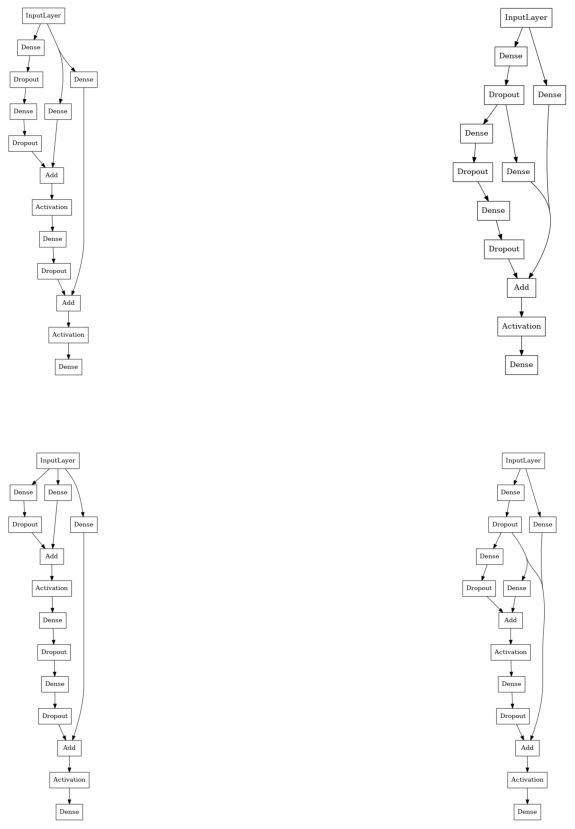

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.utils import plot_model

shapes = dict(input_shape=(10,), output_shape=(1,))
space = ResNetMLPSpace(**shapes).build()

images = []
plt.figure(figsize=(15,15))
for i in range(4):
    
    plt.subplot(2,2,i+1)
    model = space.sample()
    plot_model(model, "random_model.png", show_shapes=False, show_layer_names=False) 
    image = mpimg.imread("random_model.png")   
    plt.imshow(image)
    plt.axis('off')

plt.show()

## Create a problem instance

Let us define the neural architecture search problem.

In [6]:
from deephyper.problem import NaProblem
from deephyper.nas.preprocessing import minmaxstdscaler

problem = NaProblem()

problem.load_data(load_data)

problem.preprocessing(minmaxstdscaler)

problem.search_space(ResNetMLPSpace)

problem.hyperparameters(
    batch_size=32,
    learning_rate=0.01,
    optimizer="adam",
    num_epochs=20,
    callbacks=dict(
        EarlyStopping=dict(
            monitor="val_r2", mode="max", verbose=0, patience=5
        )
    ),
)

problem.loss("mse")

problem.metrics(["r2"])

problem.objective("val_r2__last")

print(problem)

Problem is:
 * SEED = 2019 *
    - search space   : __main__.ResNetMLPSpace
    - data loading   : __main__.load_data
    - preprocessing  : deephyper.nas.preprocessing._base.minmaxstdscaler
    - hyperparameters: 
        * verbose: 0
        * batch_size: 32
        * learning_rate: 0.01
        * optimizer: adam
        * num_epochs: 20
        * callbacks: {'EarlyStopping': {'monitor': 'val_r2', 'mode': 'max', 'verbose': 0, 'patience': 5}}
    - loss           : mse
    - metrics        : 
        * r2
    - objective      : val_r2__last



<div class="alert alert-info">
    
<b>Tip</b>
    

Adding an `EarlyStopping(...)` callback is a good idea to stop the training of your model as soon as it stops to improve.

```python
...
EarlyStopping=dict(monitor="val_r2", mode="max", verbose=0, patience=5)
...
```
    
</div>

We can first train this model to evaluate the baseline accuracy:

## Running the search

Create an `Evaluator` object using the `ray` backend to distribute the evaluation of the run-function defined previously.

In [7]:
from deephyper.evaluator import Evaluator
from deephyper.evaluator.callback import LoggerCallback
from deephyper.nas.run import run_base_trainer

evaluator = Evaluator.create(run_base_trainer, 
                 method="ray", 
                 method_kwargs={
                     "address": None, 
                     "num_cpus": 2,
                     "num_cpus_per_task": 1,
                     "callbacks": [LoggerCallback()]
                 })

print("Number of workers: ", evaluator.num_workers)

2021-10-15 15:39:43,526	INFO services.py:1263 -- View the Ray dashboard at http://127.0.0.1:8265


Number of workers:  2


<div class="alert alert-info">
    
<b>Tip</b> 
    
You can open the ray-dashboard at an address like <a>http://127.0.0.1:port</a> in a browser to monitor the CPU usage of the execution.
    
</div>

Finally, you can define a Random search called `Random` and link to it the defined `problem` and `evaluator`.

In [7]:
from deephyper.search.nas import Random

search = Random(problem, evaluator)

In [8]:
results = search.search(10)

(pid=54243) 2021-10-15 15:39:50.001490: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
(pid=54243) To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
(pid=54244) 2021-10-15 15:39:50.001472: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
(pid=54244) To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
(pid=54243) 2021-10-15 15:39:50.945603: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
(pid=54244) 2021-10-15 15:39:50.867548: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:1

[00001] -- best objective: 0.97271 -- received objective: 0.97271
[00002] -- best objective: 0.97271 -- received objective: 0.96061
[00003] -- best objective: 0.97604 -- received objective: 0.97604
[00004] -- best objective: 0.97604 -- received objective: 0.95359
[00005] -- best objective: 0.97604 -- received objective: -0.04048
[00006] -- best objective: 0.97604 -- received objective: 0.97418
[00007] -- best objective: 0.97604 -- received objective: 0.94124
[00008] -- best objective: 0.97604 -- received objective: 0.95944
[00009] -- best objective: 0.97621 -- received objective: 0.97621
[00010] -- best objective: 0.97621 -- received objective: 0.93943


After the search is over, you will find the following files in your current folder:

```
results.csv
save/
```

Let us visualize the training of our models. First, we need to load the training history of each model which are located in `save/history`:

In [9]:
import os
import json

histories = [os.path.join("save/history", f) for f in os.listdir("save/history/") if ".json" in f]

for i, fpath in enumerate(histories):
    with open(fpath, "r") as fd:
        histories[i] = json.load(fd)
        
print(list(histories[0].keys()))

['n_parameters', 'training_time', 'loss', 'r2', 'val_loss', 'val_r2']


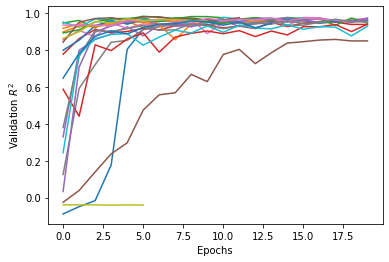

In [10]:
plt.figure()

for h in histories:
    plt.plot(h["val_r2"])

plt.ylabel("Validation $R^2$")
plt.xlabel("Epochs")
plt.show()

Once the search is over, a file named `results.csv` is saved in the current directory. The same dataframe is returned by the `search.search(...)` call. It contains the configurations evaluated during the search and their corresponding `objective` value (i.e, validation accuracy), `duration` of computation and time of computation with `elapsed_sec`. Each neural architecture is embedded as a list of discrete decision variables called `arch_seq`.

In [11]:
results

,arch_seq,id,objective,elapsed_sec,duration
0,"[87, 8, 1, 129, 0, 0, 0, 0, 0, 1, 0, 1]",2,0.972709,16.549255,13.617132
1,"[49, 2, 1, 146, 1, 0, 1, 54, 9, 0, 1, 0]",1,0.960607,17.115869,14.183806
2,"[164, 2, 1, 153, 9, 0, 1, 157, 5, 0, 1, 0]",4,0.976041,27.609628,10.492380
3,"[80, 1, 1, 169, 5, 1, 0, 58, 0, 1, 0, 1]",3,0.953587,27.764265,11.213429
4,"[151, 8, 0, 109, 7, 0, 0, 24, 2, 0, 1, 1]",6,-0.040485,31.547677,3.782598
5,"[139, 2, 1, 25, 9, 1, 1, 9, 10, 0, 0, 1]",5,0.974177,36.578103,8.967121
6,"[136, 4, 0, 149, 9, 1, 0, 120, 5, 0, 1, 0]",7,0.941240,42.664089,11.115259
7,"[7, 1, 0, 117, 6, 0, 0, 120, 3, 0, 0, 1]",8,0.959440,44.648163,8.068512
8,"[153, 0, 0, 95, 6, 0, 0, 167, 8, 1, 1, 0]",9,0.976205,49.473825,6.808688
9,"[2, 1, 1, 61, 1, 0, 1, 19, 9, 0, 1, 0]",10,0.939431,52.754221,8.105114


The `deephyper-analytics` command line is a way of analyzing this type of file. For example, we want to output the best configuration we can use the `topk` functionnality.

In [12]:
!deephyper-analytics topk results.csv -k 3

'0':
  arch_seq: '[153, 0, 0, 95, 6, 0, 0, 167, 8, 1, 1, 0]'
  duration: 6.8086879253
  elapsed_sec: 49.4738252163
  id: 9
  objective: 0.9762052894
'1':
  arch_seq: '[164, 2, 1, 153, 9, 0, 1, 157, 5, 0, 1, 0]'
  duration: 10.4923799038
  elapsed_sec: 27.6096279621
  id: 4
  objective: 0.9760414362
'2':
  arch_seq: '[139, 2, 1, 25, 9, 1, 1, 9, 10, 0, 0, 1]'
  duration: 8.9671211243
  elapsed_sec: 36.5781030655
  id: 5
  objective: 0.9741773009



Where each architecture is described as a vector of scalar values named arch_seq. In fact, each of this scalar values represents chosen operations for the variable nodes of our search space. 

## Testing the best configuration

We can visualize the architecture of the best configuration:

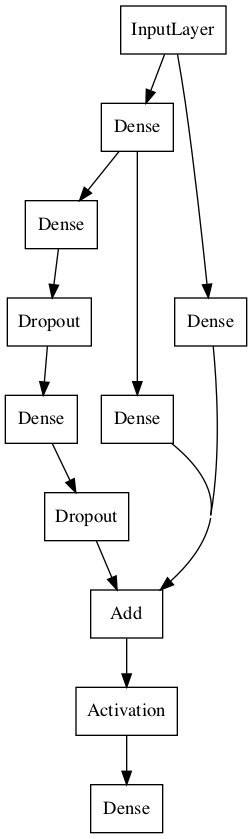

In [14]:
best_config = results.iloc[results.objective.argmax()][:-2].to_dict()
arch_seq = json.loads(best_config["arch_seq"])
model = space.sample(arch_seq)
plot_model(model, show_shapes=False, show_layer_names=False) 